In [1]:
# Phantom Research: Pavement Maintenance Prediction Tool

In [2]:
# Install packages
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install -U scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import packages
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

In [4]:
# PHASE ONE: LOAD DATASET

In [50]:
# Static variables
pavement_file = "gdot_pavement_dataset.csv"
user_input = {}

In [56]:
# Load dataset into dataframe
raw_data = pd.read_csv(pavement_file)
df = raw_data

In [7]:
# PHASE TWO: INITIAL DATA EXPLORATION

In [8]:
# Inspect structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Segment ID         1050000 non-null  object 
 1   PCI                1050000 non-null  float64
 2   Road Type          1050000 non-null  object 
 3   AADT               1050000 non-null  int64  
 4   Asphalt Type       1050000 non-null  object 
 5   Last Maintenance   1050000 non-null  int64  
 6   Average Rainfall   1050000 non-null  float64
 7   Rutting            1050000 non-null  float64
 8   IRI                1050000 non-null  float64
 9   Needs Maintenance  1050000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 80.1+ MB


In [9]:
df

,Segment ID,PCI,Road Type,AADT,Asphalt Type,Last Maintenance,Average Rainfall,Rutting,IRI,Needs Maintenance
0,SID 155440,70.00,Secondary,4634,Concrete,2022,42.07,15.11,0.68,0
1,SID 244365,37.87,Tertiary,3474,Asphalt,2017,79.60,19.67,0.99,1
2,SID 137867,88.32,Tertiary,1734,Concrete,2019,62.69,14.73,0.50,0
3,SID 540519,52.30,Tertiary,3119,Asphalt,2008,79.32,17.01,1.04,1
4,SID 745776,49.10,Tertiary,3505,Asphalt,2019,71.81,21.08,1.18,1
...,...,...,...,...,...,...,...,...,...,...
1049995,SID 766608,60.37,Tertiary,2048,Concrete,2018,62.95,11.60,0.52,0
1049996,SID 594559,89.70,Secondary,3792,Concrete,2019,54.06,13.06,0.58,0
1049997,SID 345069,75.59,Secondary,33876,Concrete,2019,54.52,16.78,0.53,0
1049998,SID 472153,89.31,Tertiary,259,Asphalt,2025,63.54,16.07,0.70,0


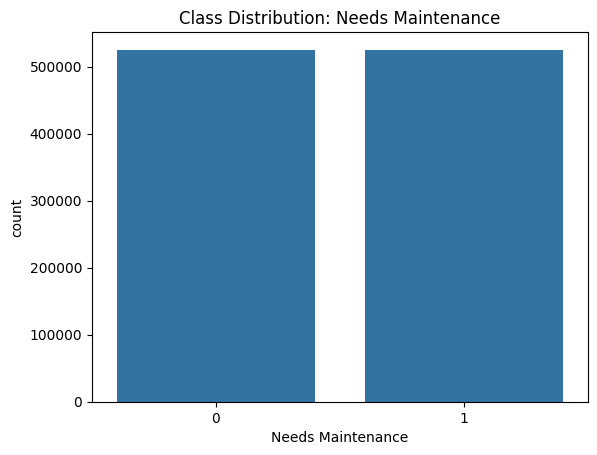

Needs Maintenance
0    525131
1    524869
Name: count, dtype: int64


In [10]:
# Generate "Needs Maintenance" class distribution histogram.
# The almost equal distribution between the two classes (0 and 1) indicates no bias toward either outcome.
# Unbias dataset is important for training a fair and reliable classification model.
sns.countplot(x='Needs Maintenance', data=df)
plt.title("Class Distribution: Needs Maintenance")
plt.show()
print(df['Needs Maintenance'].value_counts())

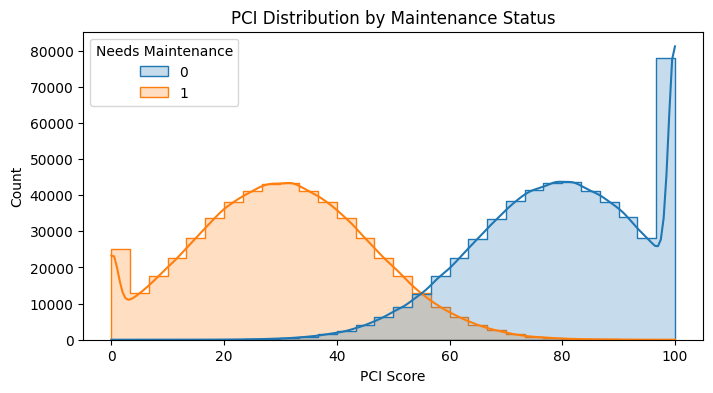

In [11]:
# Generate Pavement Condition Index (PCI) distribution by Maintenance Status histogram.
# Source: https://faapaveair.faa.gov/Help/index.html?AspxAutoDetectCookieSupport=1#!Documents/pavementconditionindexpci.htm
# Graph confirms hypothesis that a healthy, higher score tend to not need maintenance.
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='PCI', hue='Needs Maintenance', bins=30, kde=True, element='step', common_norm=False)
plt.title("PCI Distribution by Maintenance Status")
plt.xlabel("PCI Score")
plt.show()

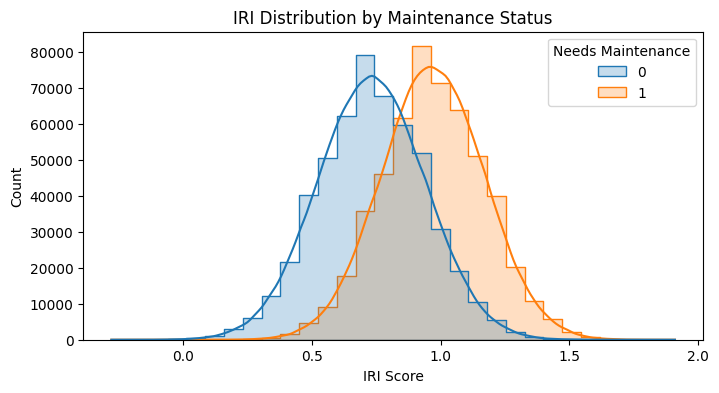

In [12]:
# Generate International Roughness Index (IRI) Distribution by Maintenance Status histogram.
# Source: https://www.pavement.com.au/news/the-international-roughness-index-iri
# Graph indicates there is a tendency for a higher IRI score requiring maintenance.
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='IRI', hue='Needs Maintenance', bins=30, kde=True, element='step', common_norm=False)
plt.title("IRI Distribution by Maintenance Status")
plt.xlabel("IRI Score")
plt.show()

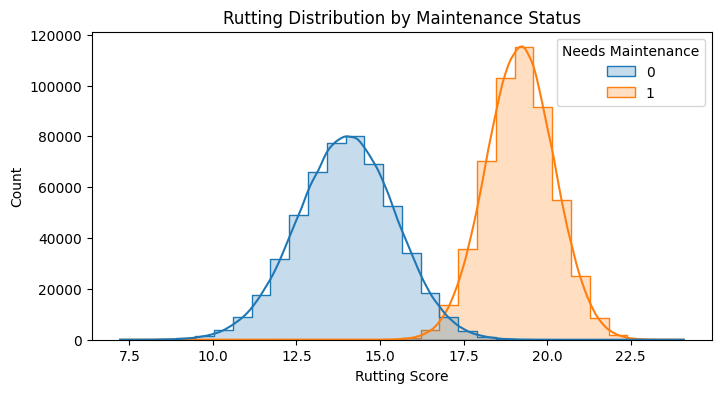

In [13]:
# Generate Rutting Distribution by Maintenance Status histrogram
# Graph indicates that a deeper rutting or depression in pavement requiring maintenance.
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Rutting', hue='Needs Maintenance', bins=30, kde=True, element='step', common_norm=False)
plt.title("Rutting Distribution by Maintenance Status")
plt.xlabel("Rutting Score")
plt.show()

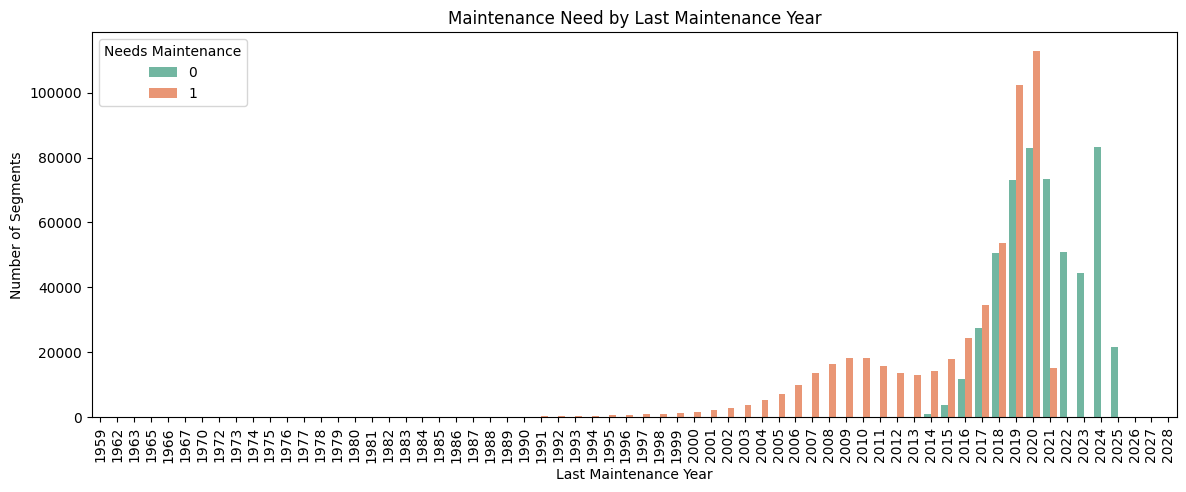

In [14]:
# Generate Maintenance Need by Last Maintenance Year histogram
plt.figure(figsize=(14, 5))
sns.countplot(data=df, x='Last Maintenance', hue='Needs Maintenance', palette='Set2')
plt.title('Maintenance Need by Last Maintenance Year')
plt.xlabel('Last Maintenance Year')
plt.ylabel('Number of Segments')
plt.xticks(rotation=90)
plt.show()

In [15]:
# PHASE THREE: PREPROCESSING

In [16]:
# Check for missing values
df.isnull().sum()

Segment ID           0
PCI                  0
Road Type            0
AADT                 0
Asphalt Type         0
Last Maintenance     0
Average Rainfall     0
Rutting              0
IRI                  0
Needs Maintenance    0
dtype: int64

In [17]:
# Check for duplicates records
duplicate_count = df.duplicated(subset="Segment ID").sum()
f"Duplicate Segment IDs: {duplicate_count}"

'Duplicate Segment IDs: 0'

In [18]:
# Drop Segment ID as it is not useful for training
df = df.drop(columns=['Segment ID'])

In [19]:
# One-hot encode categorical columns 'Road Type' and 'Asphalt Type' into new binary columns
df = pd.get_dummies(df, columns=["Road Type", "Asphalt Type"], drop_first=True)

In [20]:
# Feature engineer column 'Last Maintenance' into 'Years Since Maintenance' column
df['Years Since Maintenance'] = 2025 - df['Last Maintenance']

# Drop old column
df = df.drop(columns=['Last Maintenance'])

In [21]:
# Scale numerical values to improve machine learning algorithms
scaler = StandardScaler()
columns = ['PCI', 'AADT', 'Average Rainfall', 'Rutting', 'IRI', 'Years Since Maintenance']
df[columns] = scaler.fit_transform(df[columns])

In [22]:
# Confirm clean dataframe
df

,PCI,AADT,Average Rainfall,Rutting,IRI,Needs Maintenance,Road Type_Secondary,Road Type_Tertiary,Asphalt Type_Concrete,Years Since Maintenance
0,0.531421,-0.498371,-1.270869,-0.512542,-0.718616,0,True,False,True,-0.773167
1,-0.585106,-0.581879,0.810830,1.064575,0.591184,1,False,True,False,0.230038
2,1.168047,-0.707141,-0.127128,-0.643969,-1.479144,0,False,True,True,-0.171244
3,-0.083659,-0.607435,0.795299,0.144590,0.802441,1,False,True,False,2.035808
4,-0.194860,-0.579647,0.378737,1.552236,1.393964,1,False,True,False,-0.171244
...,...,...,...,...,...,...,...,...,...,...
1049995,0.196776,-0.684536,-0.112706,-1.726507,-1.394641,0,False,True,True,0.029397
1049996,1.216002,-0.558986,-0.605813,-1.221553,-1.141131,0,True,False,True,-0.171244
1049997,0.725675,1.606747,-0.580298,0.065042,-1.352389,0,True,False,True,-0.171244
1049998,1.202450,-0.813325,-0.079980,-0.180517,-0.634112,0,False,True,False,-1.375090


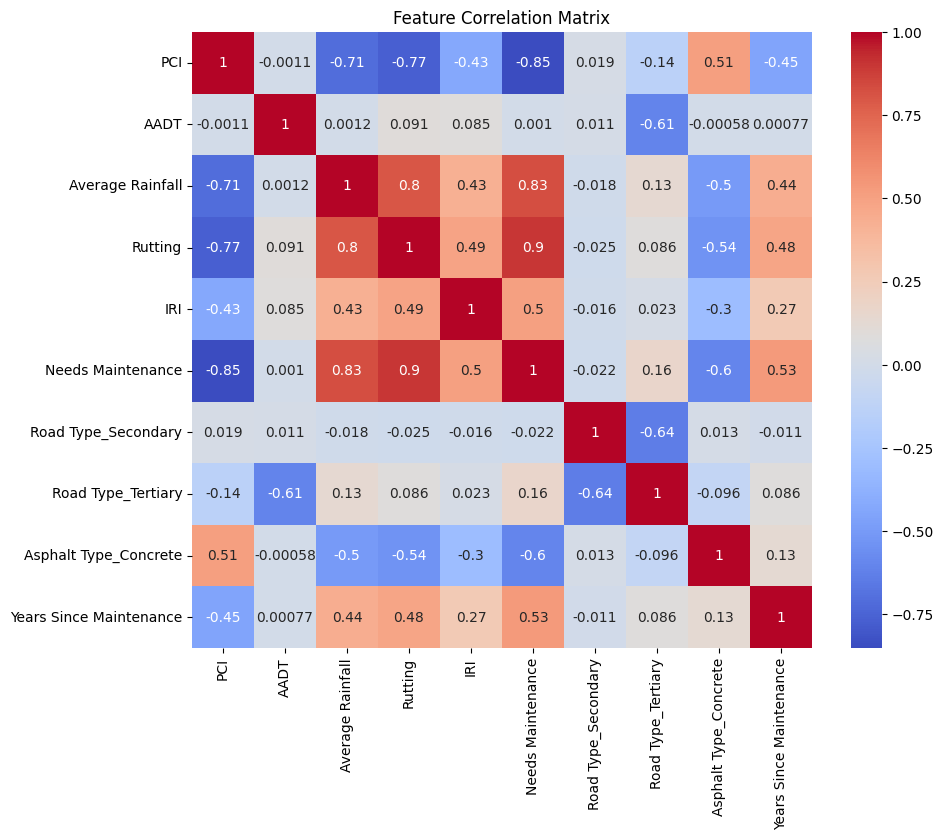

In [23]:
# Generate Feature Correlation Matrix
# Matrix indicates a strong requires maintenance relationship with avg rainfaill, rutting and IRI features.
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [24]:
# PHASE FOUR: TRAIN MACHINE LEARNING MODELS

In [25]:
# Separate target feature 'Needs Maintenance' from data features
features = df.drop(columns=['Needs Maintenance'])
target = df['Needs Maintenance']

In [26]:
# Split into training and test sets by 80/20
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [27]:
# Train a Logistic Regression Model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(features_train, target_train)

target_pred_lr = lr.predict(features_test)

print("Logistic Regression Classification Report:")
print(classification_report(target_test, target_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105026
           1       1.00      1.00      1.00    104974

    accuracy                           1.00    210000
   macro avg       1.00      1.00      1.00    210000
weighted avg       1.00      1.00      1.00    210000



In [28]:
# Train a Random Forest Classifier (this may take a few minutes to calculate)
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(features, target)

target_pred_rf = rf.predict(features_test)

print("Random Forest Classification Report:")
print(classification_report(target_test, target_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105026
           1       1.00      1.00      1.00    104974

    accuracy                           1.00    210000
   macro avg       1.00      1.00      1.00    210000
weighted avg       1.00      1.00      1.00    210000



In [29]:
# PHASE FIVE: MODEL EVALUATION

In [30]:
# Cross-validation of Logistic Regression (Ashe 2023)
# Source: https://ashejim.github.io/C964/task2_c/example_sup_class/sup_class_ex-accuracy.html
lr_scores = cross_val_score(lr, features, target, cv=5, scoring='f1')
print("5-fold CV F1 scores:", lr_scores)
print("Mean F1 score:", lr_scores.mean())

5-fold CV F1 scores: [0.99992855 0.99989998 0.99989522 0.99994761 0.99991903]
Mean F1 score: 0.9999180772295772


In [31]:
# Cross-validation of Random Forest Classifier (This may take a few minutes to calculate) (Ashe 2023)
# Source: https://ashejim.github.io/C964/task2_c/example_sup_class/sup_class_ex-accuracy.html
rf_scores = cross_val_score(rf, features, target, cv=5, scoring='f1')
print("5-fold CV F1 scores:", rf_scores)
print("Mean F1 score:", rf_scores.mean())

5-fold CV F1 scores: [0.99997618 0.99999524 0.99996666 0.99999047 0.99996666]
Mean F1 score: 0.9999790423660286


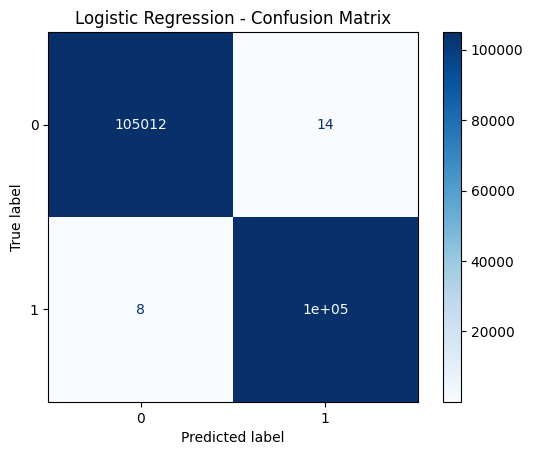

In [32]:
# Logistic Regression Confusion Matrix (Ashe 2023)
# Source: https://ashejim.github.io/C964/task2_c/example_sup_class/sup_class_ex-accuracy.html
cm = confusion_matrix(target_test, target_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

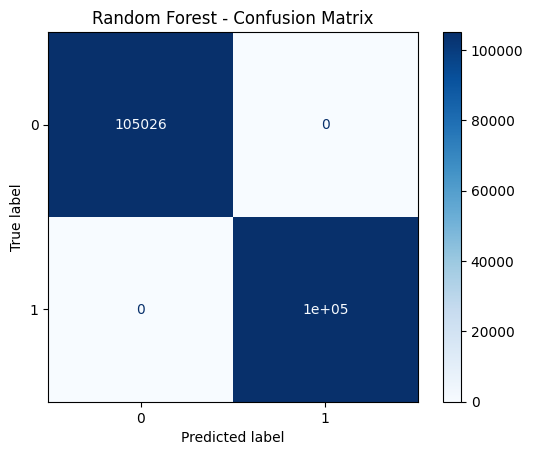

In [33]:
# Random Forest Confusion Matrix (Ashe 2023)
# Source: https://ashejim.github.io/C964/task2_c/example_sup_class/sup_class_ex-accuracy.html
cm = confusion_matrix(target_test, target_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.show()

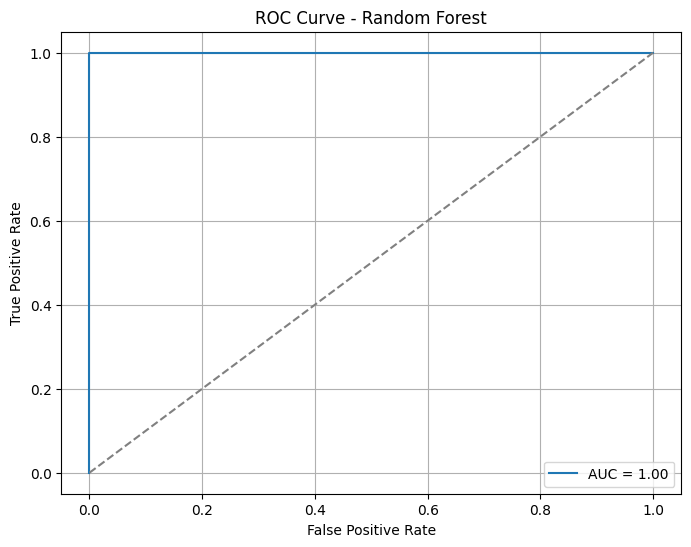

In [34]:
# Show model performance across thresholds with ROC Curve and AUC (Ashe 2023)
target_proba = rf.predict_proba(features_test)[:, 1]
fpr, tpr, _ = roc_curve(target_test, target_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(target_test, target_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()

In [35]:
# Logistic Regression Feature Importance By Examining Coefficient Magnitude (Ashe 2023)
coefficients = lr.coef_[0]
feature_names = features.columns

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
print(feature_importance)

                   Feature  Coefficient  Absolute_Coefficient
7    Asphalt Type_Concrete    -7.880186              7.880186
3                  Rutting     6.000896              6.000896
8  Years Since Maintenance     5.314357              5.314357
0                      PCI    -3.506182              3.506182
2         Average Rainfall     2.427414              2.427414
6       Road Type_Tertiary     1.858452              1.858452
5      Road Type_Secondary     1.246451              1.246451
4                      IRI     0.604154              0.604154
1                     AADT    -0.087921              0.087921


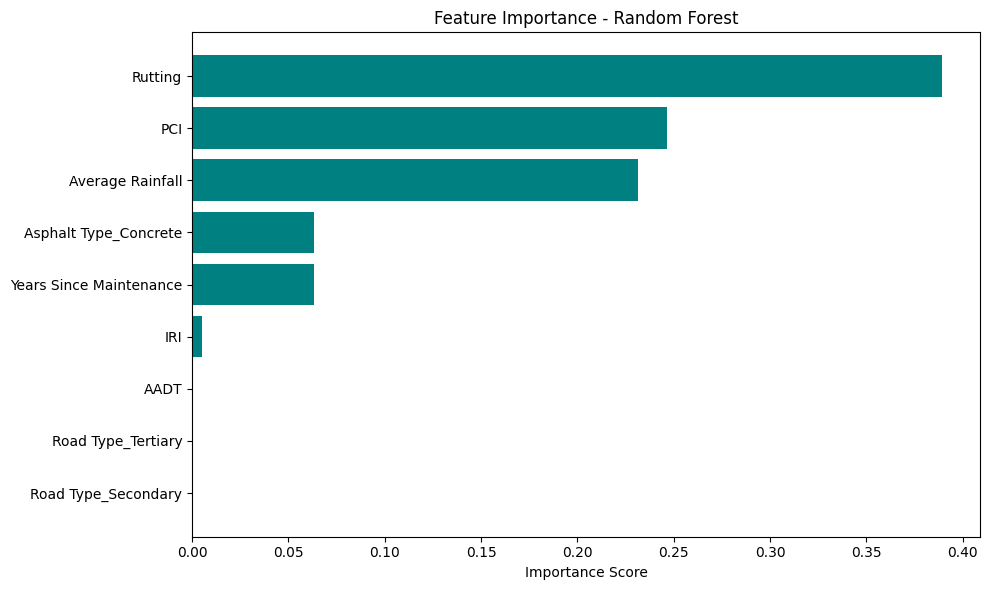

In [36]:
# Random Forest Feature Importance (Ashe 2023)
importances = rf.feature_importances_
feature_names = features_train.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10,6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color='teal')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

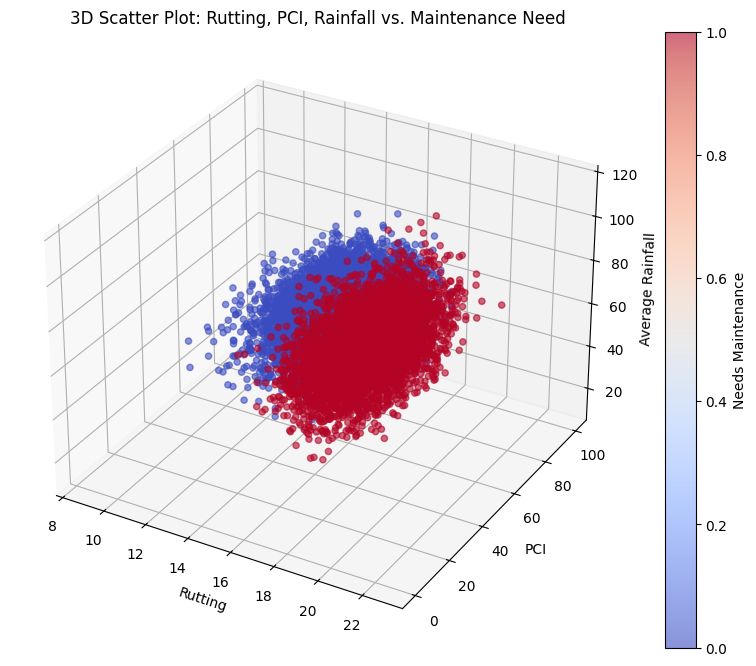

In [62]:
# Plot a 3D scatter plot of the top 3 features: Rutting, PCI, and Avg Rainfall
sample_df = df.sample(10000)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    sample_df['Rutting'],
    sample_df['PCI'],
    sample_df['Average Rainfall'],
    c=sample_df['Needs Maintenance'],
    cmap='coolwarm',
    alpha=0.6
)

ax.set_xlabel('Rutting')
ax.set_ylabel('PCI')
ax.set_zlabel('Average Rainfall')
plt.title("3D Scatter Plot: Rutting, PCI, Rainfall vs. Maintenance Need")
plt.colorbar(sc, label='Needs Maintenance')
plt.show()

In [38]:
# PHASE SIX: USER INTERFACE

In [45]:
# Create UI for all features
description_width = {'description_width': '250px'}
wide_layout = widgets.Layout(width='500px')

pci_slider = widgets.FloatSlider(
    value=70,
    min=0,
    max=100,
    step=1,
    description='Pavement Condition Index',
    continuous_update=False,
    style=description_width,
    layout=wide_layout
)

road_type_dropdown = widgets.Dropdown(
    options=['Primary', 'Secondary', 'Tertiary'],
    value='Secondary',
    description='Road Type',
    style=description_width,
    layout=wide_layout
)

aadt_slider = widgets.IntSlider(
    value=50,
    min=0,
    max=50000,
    step=1,
    description='Average Daily Traffic',
    continuous_update=False,
    style=description_width,
    layout=wide_layout
)

asphalt_type_dropdown = widgets.Dropdown(
    options=['Concrete', 'Asphalt'],
    value='Concrete',
    description="Asphalt Type",
    continuous_update=False,
    style=description_width,
    layout=wide_layout
)

rainfall_slider = widgets.FloatSlider(
    value=0.0,
    min=0,
    max=100.0,
    step=0.5,
    description='Avg Rainfall (in)',
    continuous_update=False, 
    style=description_width,
    layout=wide_layout
)

rutting_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=30.0,
    step=0.1,
    description='Rutting',
    continuous_update=False,
    style=description_width,
    layout=wide_layout
)

iri_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=8.0,
    steps=0.1,
    description="International Roughness Index",
    continuous_update=False,
    style=description_width,
    layout=wide_layout
)

years_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Years Since Maint.',
    continuous_update=False,
    style=description_width,
    layout=wide_layout
)

In [51]:
def predict(pci, road_type, aadt, rainfall, rutting, iri, asphalt_type, years_since_maintenance):
    global user_input
    # Save inputs in a dict (you can store scaled or raw as needed)
    user_input = {
        'pci': pci,
        'road_type': road_type,
        'aadt': aadt,
        'rainfall': rainfall,
        'rutting': rutting,
        'iri': iri,
        'asphalt_type': asphalt_type,
        'years_since_maintenance': years_since_maintenance
    }
    
    # Encode Road Type
    road_type_secondary = 0
    road_type_tertiary = 0
    if road_type == 'Secondary':
        road_type_secondary = 1
    elif road_type == 'Tertiary':
        road_type_tertiary = 1

    # Encode Asphalt Type
    asphalt_type_concrete = 1 if asphalt_type == 'Concrete' else 0

    # Create a DataFrame with proper column names
    input_dict = {
        'PCI': [pci],
        'AADT': [aadt],
        'Average Rainfall': [rainfall],
        'Rutting': [rutting],
        'IRI': [iri],
        'Years Since Maintenance': [years_since_maintenance]
    }
    input_df = pd.DataFrame(input_dict)
    
    # Scale numeric features
    scaled_numeric = scaler.transform(input_df)
    scaled_df = pd.DataFrame(scaled_numeric, columns=input_df.columns)

    # Add categorical features (not scaled)
    scaled_df['Road Type_Secondary'] = road_type_secondary
    scaled_df['Road Type_Tertiary'] = road_type_tertiary
    scaled_df['Asphalt Type_Concrete'] = asphalt_type_concrete

    # Reorder to match model training order
    feature_order = rf.feature_names_in_
    scaled_df = scaled_df[feature_order]
    
    # Predict
    prediction = lr.predict(scaled_df)[0]
    print(f"\nPrediction: {'Maintenance Required' if prediction == 1 else 'No Maintenance Needed'}")

In [59]:
def plot_user_input():
    global user_input

    pci = user_input.get('pci', None)
    rutting = user_input.get('rutting', None)
    rainfall = user_input.get('rainfall', None)
    
    # Use last_input global dict here
    if not user_input:
        print("No user input to plot yet.")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Rutting
    sns.histplot(raw_data['Rutting'], bins=30, ax=axes[1], kde=True)
    axes[0].axvline(rutting, color='red', linestyle='--', linewidth=2)
    axes[0].set_title("Rutting Distribution")
    axes[0].set_xlabel("Rutting (mm)")
    
    # PCI
    sns.histplot(raw_data['PCI'], bins=30, ax=axes[0], kde=True)
    axes[1].axvline(pci, color='red', linestyle='--', linewidth=2)
    axes[1].set_title("PCI Distribution")
    axes[1].set_xlabel("PCI")

    # Rainfall
    sns.histplot(raw_data['Average Rainfall'], bins=30, ax=axes[2], kde=True)
    axes[2].axvline(rainfall, color='red', linestyle='--', linewidth=2)
    axes[2].set_title("Average Rainfall Distribution")
    axes[2].set_xlabel("Rainfall (mm)")

    plt.tight_layout()
    plt.show()

In [60]:
# Generate interactive UI
# --------- Instructions --------- 
# 1. Select values for each slider and dropdown
# 2. The prediction will instantly update below the slider

interactive_ui = widgets.interactive(
    predict,
    pci=pci_slider,
    aadt=aadt_slider,
    road_type=road_type_dropdown,
    rainfall=rainfall_slider,
    rutting=rutting_slider,
    iri=iri_slider,
    asphalt_type=asphalt_type_dropdown,
    years_since_maintenance=years_slider,
)

display(interactive_ui)

interactive(children=(FloatSlider(value=70.0, continuous_update=False, description='Pavement Condition Index',…

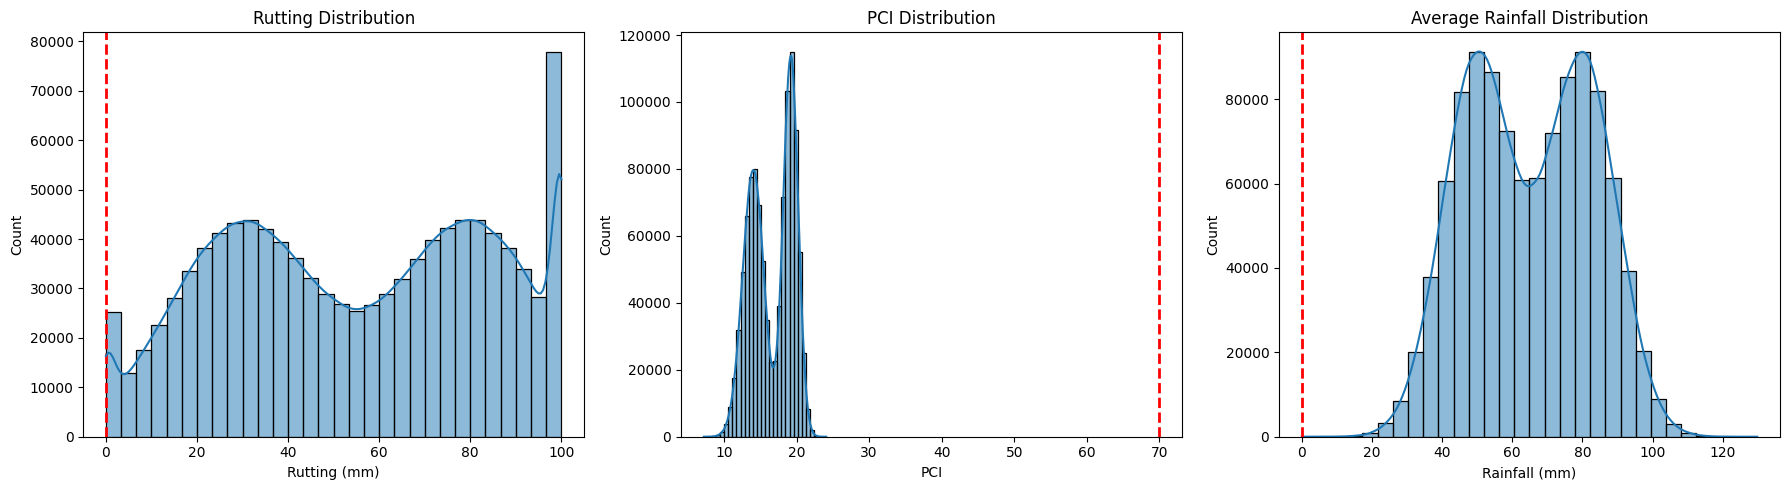

In [61]:
# Generate PCI, Rutting, and Rainfall Distribution Scatterplots with user input (This may take a few minutes to calculate)
# Dotted red line identifies user input
plot_user_input()